# Data preparation for Vizgen

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

sc.logging.print_header()

scanpy==1.9.0.dev183+gd74a0e68 anndata==0.8.0rc2.dev27+ge524389 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


## Download the data, unpack and load to anndata

Download the data from [Vizgen MERFISH Mouse Brain Receptor Dataset](https://info.vizgen.com/mouse-brain-map?submissionGuid=a66ccb7f-87cf-4c55-83b9-5a2b6c0c12b9). Unpack the `.tar.gz` file. The dataset contains a MERFISH measurement of a gene panel containing 483 total genes including canonical brain cell type markers, GPCRs, and RTKs measured on 3 full coronal slices across 3 biological replicates. This is one slice of replicate 1.

Unfortunately, the data needs to be downloaded manually. You need these 3 files in a new folder `tutorial_data` in the same path as your notebook. 
- `datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv`
- `datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv`
- `datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_images_micron_to_mosaic_pixel_transform.csv`
The last file should be in the `images` folder.

The following lines create the folder structure which can be use to load the data.

In [2]:
# # # Download and unpack the Vizgen data
# !mkdir tutorial_data
# !mkdir tutorial_data/vizgen_data
# !mkdir tutorial_data/vizgen_data/images

In [3]:
vizgen_dir = Path().resolve() / "tutorial_data" / "vizgen_data"

adata = sq.read.vizgen(
    path=vizgen_dir,
    counts_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv",
    meta_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv",
    transformation_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_images_micron_to_mosaic_pixel_transform.csv",
)

### Make the variable names unique, filter the mitochondrial genes

Make the variable names unique using the method `anndata.var_names_make_unique`.
Obtain the mitochondrial genes using their names prefixed with "mt-".
Calculate the quality control metrics on the `anndata.AnnData` using `scanpy.pp.calculate_qc_metrics`.

In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)

# Calculate quality control metrics

Plot the "total_counts" and "n_genes_by_counts" from `anndata.obs`.
The first subplot shows `adata.obs["total_counts"]`, the second `adata.obs["total_counts"]` less than 10000.
The third subplot displays `adata.obs["n_genes_by_counts"]` while the fourth displays the `adata.obs["n_genes_by_counts"]` less than 4000.

/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

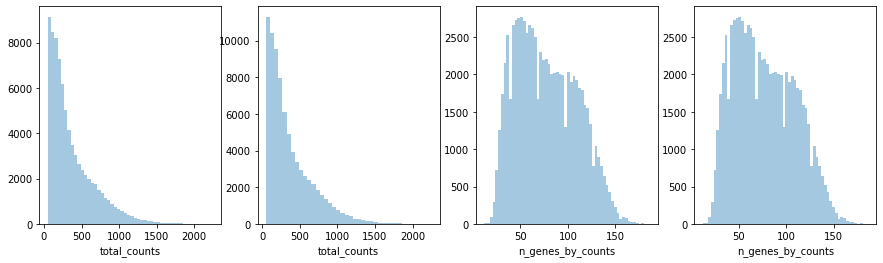

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)
sns.distplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.distplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    bins=60,
    ax=axs[2],
)
sns.distplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

Filter the cells based on the minimum number of counts required using `scanpy.pp.filter_cells`. Filter the genes based on the minimum number of cells required with `scanpy.pp.filter_genes`. The parameters for the both were specified based on the plots above. They were set to filter out the cells and genes with minimum counts and minimum cells respectively.

In [6]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=10)

# Annotate the genes, normalize counts per cell

Annotate the highly variable genes based on the count data by using `scanpy.pp.highly_variable_genes` with `flavor="seurat_v3"`. Normalize counts per cell using `scanpy.pp.normalize_total`.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using `scanpy.pp.log1p`, `scanpy.pp.pca` and `scanpy.pp.neighbors` respectively.

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

You may have to install `scikit-misc` package for highly variable genes identification.

In [7]:
# !pip install scikit-misc

In [8]:
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Plot UMAP

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts, and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.

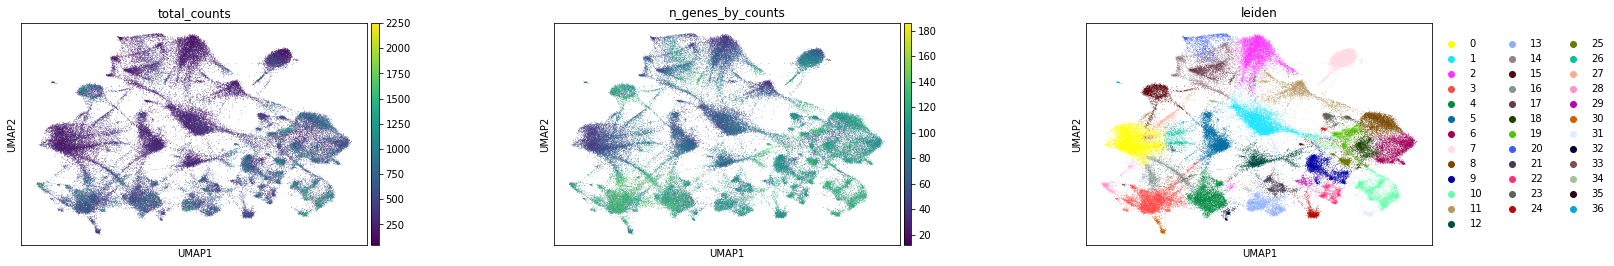

In [9]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

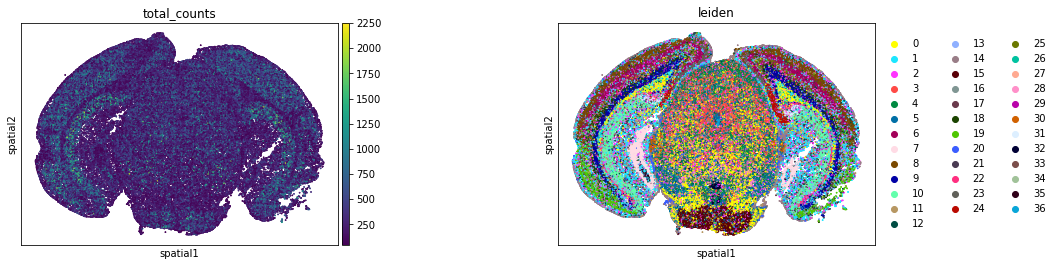

In [12]:
sq.pl.spatial_scatter(adata, shape=None,color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,)

----

# Computation of spatial statistics

## Compute centrality scores

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:
* closeness centrality - measure of how close the group is to other nodes.
* clustering coefficient - measure of the degree to which nodes cluster together.
* degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups' annotations in `anndata.AnnData.obs`, which are used for calculation of centrality scores.

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use `squidpy.gr.spatial_neighbors` for this purpose. We use the `coord_type="generic"` based on the data and the neighbors are classified with Delaunay triangulation by specifying `delaunay=True`.

In [13]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

Centrality scores are calculated with `squidpy.gr.centrality_scores`, with the Leiden groups as clusters.

In [14]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using `squidpy.pl.centrality_scores`.

/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


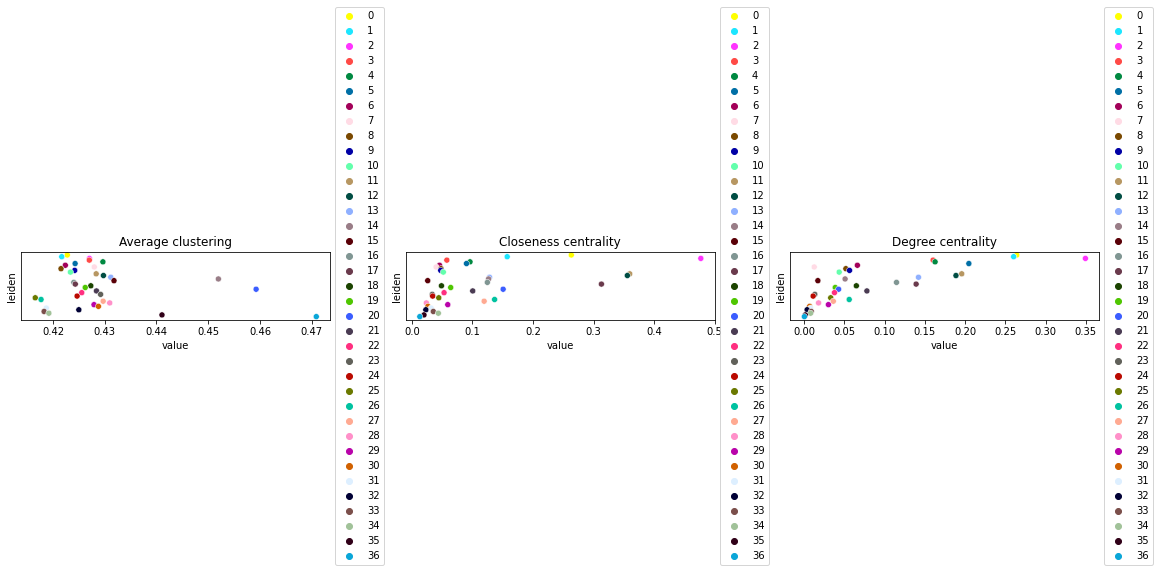

In [15]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))

----

# Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

$$\frac{p(exp|cond)}{p(exp)}$$
where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
cell in the tissue.

We can compute the co-occurrence score with `squidpy.gr.co_occurrence`.
Results of co-occurrence probability ratio can be visualized with `squidpy.pl.co_occurrence`. The '3' in the $\frac{p(exp|cond)}{p(exp)}$ represents a Leiden clustered group.

We can further visualize tissue organization in spatial coordinates with `squidpy.pl.spatial_scatter`, with an overlay of the expressed genes which were colored in consonance with the Leiden clusters.

In [16]:
adata_subsample = sc.pp.subsample(adata, fraction=0.5, copy=True)

100%|█| 210/210 [01:47<00:00,  1.


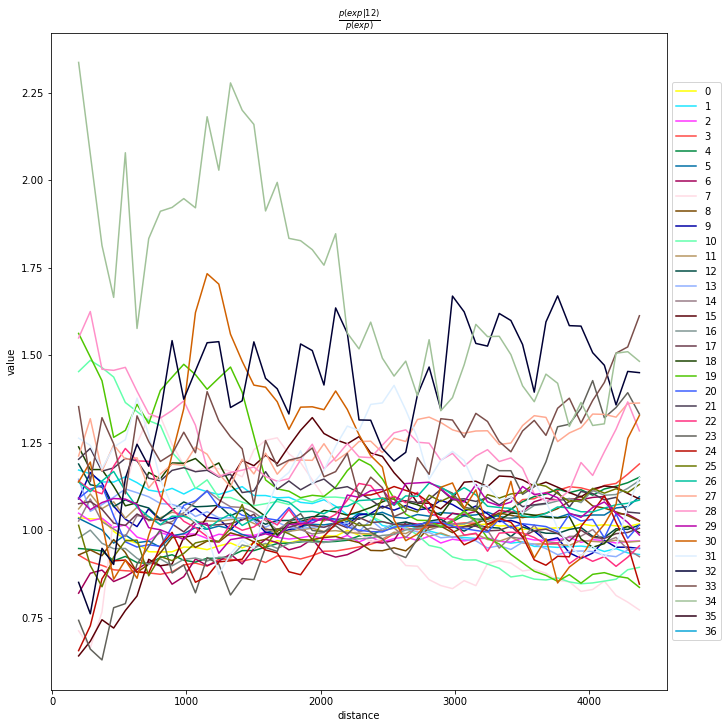

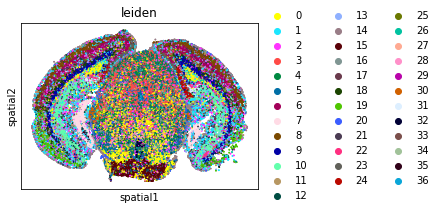

In [17]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
    clusters="12",
    figsize=(10, 10),
)
sq.pl.spatial_scatter(
    adata_subsample,
    color="leiden",
    shape=None,
    size=2,
)

----

## Neighbors enrichment analysis

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against $N$ permutations and a *z-score* is computed.

This dataset contains cell type annotations in `anndata.Anndata.obs` which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with `squidpy.gr.nhood_enrichment`.

In [18]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

100%|█| 1000/1000 [00:15<00:00, 6


And visualize the results with `squidpy.pl.nhood_enrichment`.

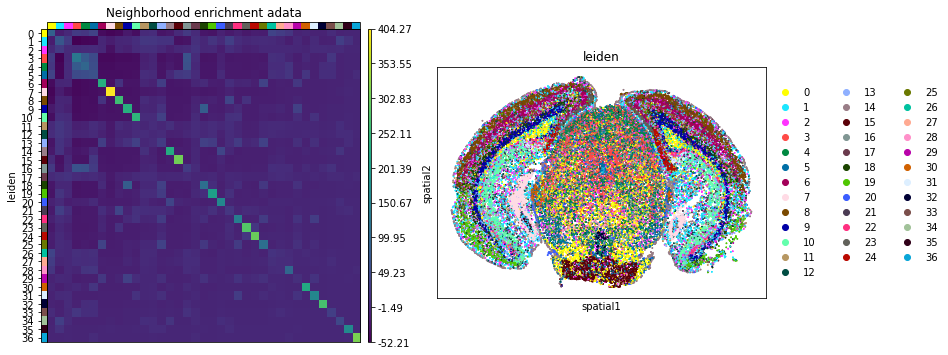

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata_subsample, color="leiden", shape=None, size=2, ax=ax[1])

----

## Compute Ripley's statistics

This example shows how to compute the Ripley's L function.

The Ripley's L function is a descriptive statistics function generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale. The Ripley's L is a variance-normalized version of the Ripley's K statistic. There are also 2 other Ripley's statistics available (that are closely related): 'G' and 'F'.

Ripley's G monitors the portion of points for which the nearest neighbor is within a given distance threshold, and plots that cumulative percentage against the increasing distance radii.

For increasing separation range, Ripley's F function assembles the percentage of points which can be found in the aforementioned range from an arbitrary point pattern spawned in the expanse of the noticed pattern. 

We can compute the Ripley's L function with `squidpy.gr.ripley`.
Results can be visualized with `squidpy.pl.ripley`. The other Ripley's statistics can be specified using `mode = 'G'` or `mode = 'F'`.

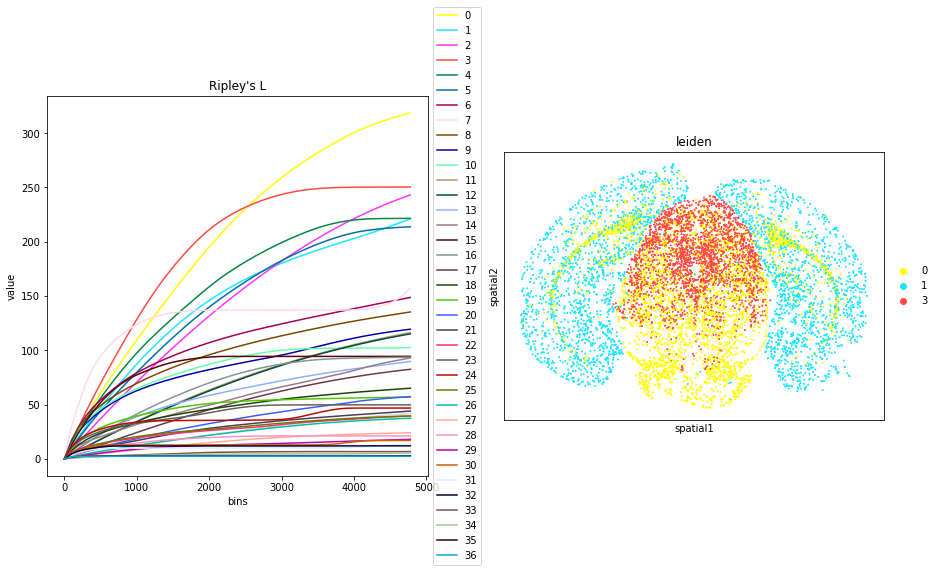

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
mode = "L"

sq.gr.ripley(adata, cluster_key="leiden", mode=mode)
sq.pl.ripley(adata, cluster_key="leiden", mode=mode, ax=ax[0])

sq.pl.spatial_scatter(
    adata_subsample,
    color="leiden",
    groups=["0", "1", "3"],
    shape=None,
    size=2,
    ax=ax[1],
)

----

## Compute Moran's I score

This example shows how to compute the Moran's I global spatial auto-correlation statistics.

The Moran's I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran's I score with `squidpy.gr.spatial_autocorr` and `mode = 'moran'`. We first need to compute a spatial graph with `squidpy.gr.spatial_neighbors`. We will also subset the number of genes to evaluate.

In [24]:
sq.gr.spatial_neighbors(adata_subsample, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_subsample,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subsample.uns["moranI"].head(10)

100%|██████████| 100/100 [18:37<00:00, 11.17s/]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Slc17a7,0.741794,0.0,0.000012,0.0,0.009901,0.000026,0.0,0.0,0.014935
Chrm1,0.645018,0.0,0.000012,0.0,0.009901,0.000018,0.0,0.0,0.014935
Gfap,0.578457,0.0,0.000012,0.0,0.009901,0.000017,0.0,0.0,0.014935
Baiap2,0.478913,0.0,0.000012,0.0,0.009901,0.000016,0.0,0.0,0.014935
Sstr4,0.464468,0.0,0.000012,0.0,0.009901,0.000020,0.0,0.0,0.014935
Glp2r,0.458457,0.0,0.000012,0.0,0.009901,0.000022,0.0,0.0,0.014935
Mas1,0.448021,0.0,0.000012,0.0,0.009901,0.000021,0.0,0.0,0.014935
Grin2b,0.441957,0.0,0.000012,0.0,0.009901,0.000013,0.0,0.0,0.014935
Gprc5b,0.427084,0.0,0.000012,0.0,0.009901,0.000013,0.0,0.0,0.014935
Npy2r,0.426206,0.0,0.000012,0.0,0.009901,0.000019,0.0,0.0,0.014935


We can visualize some of those genes with `squidpy.pl.spatial_scatter`. We could also pass `mode = 'geary'` to compute a closely related auto-correlation statistic, [Geary's C](https://en.wikipedia.org/wiki/Geary%27s_C). See `squidpy.gr.spatial_autocorr` for more information.

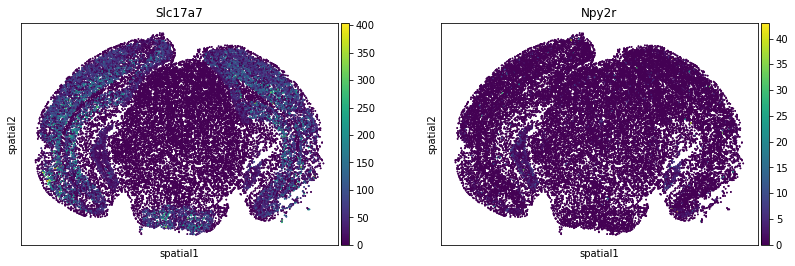

In [62]:
sq.pl.spatial_scatter(
    adata_subsample,
    color=[
        "Slc17a7",
        "Npy2r",
    ],
    shape=None,
    size=2,
    img=False,
)